In [1]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# machine learning stack
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder)
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# time-related stack
import time


# miscellaneous
import warnings
warnings.filterwarnings("ignore")
# timestamp manipulation stack
from dateutil.relativedelta import relativedelta
from scipy.signal import savgol_filter
import helpy



In [2]:
df = pd.read_csv("ECA_blended_custom/TG_STAID002759.txt",
                # data starts from line 20
                skiprows = 19,
                # remove empty space in column name
                skipinitialspace = True,
                # parse DATE column 1
                parse_dates = [1])

In [3]:
df.columns = ["id", "date", "temp", "quality"]

In [4]:
df

,id,date,temp,quality
0,127488,1876-01-01,22,0
1,127488,1876-01-02,25,0
2,127488,1876-01-03,3,0
3,127488,1876-01-04,-58,0
4,127488,1876-01-05,-98,0
...,...,...,...,...
53776,111448,2023-03-27,34,0
53777,111448,2023-03-28,35,0
53778,111448,2023-03-29,66,0
53779,111448,2023-03-30,117,0


In [5]:
df_missing = df[df['quality']==9]
# first date with missing values
df_missing['date'].min()
# last date with missing values
df_missing['date'].max()
# days with missing values
missnig_days = (df_missing['date'].max() - df_missing['date'].min()).days + 1
missnig_days

195

In [6]:
# check if all days in between have missing values
missnig_days == df_missing.shape[0]

True

In [7]:
df.groupby('quality').count()

,id,date,temp
quality,,,
0,53586,53586,53586
9,195,195,195


In [8]:
# reference years are all years 5 years before and  5 years after
reference_years = list(range(-5,6))
reference_years.remove(0)
# function for clean temperature values
def clean_temp(df,x):
    """
    returns a temperaure column in celcius with missing values imputed;
    imputation is done with the average of the temperautes on the same
    year over all the reference years; division by 10 for celcius value
    """
    # if missing value occurs
    if x['quality']==9:
        # list reference dates
        reference_dates = [x['date']+relativedelta(years=y) for y in reference_years]
        # mean temperatue over the references dates
        temp_value = df[df['date'].isin(reference_dates)]['temp'].mean()
        # division by 10 to convert to celcius value
        return int(temp_value)/10
    # else just division by 10 to convert to celcius value
    return x['temp']/10

In [9]:
# create clean temperatutre column
df['temp'] = df.apply(lambda x: clean_temp(df,x), axis=1)

In [10]:
# Add timestep colum
df["timestep"] = list(range(df.shape[0]))
clean_df = df.set_index('date')[['temp', "timestep", "quality"]]

In [11]:
clean_df

,temp,timestep,quality
date,,,
1876-01-01,2.2,0,0
1876-01-02,2.5,1,0
1876-01-03,0.3,2,0
1876-01-04,-5.8,3,0
1876-01-05,-9.8,4,0
...,...,...,...
2023-03-27,3.4,53776,0
2023-03-28,3.5,53777,0
2023-03-29,6.6,53778,0


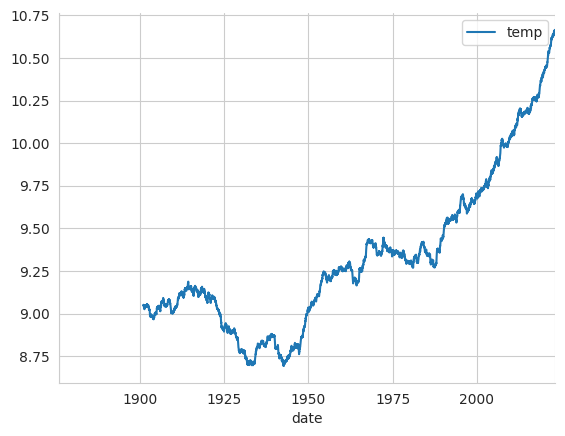

In [12]:
def rolling_mean_plot(series,years):
    window = int(years * 365.24)
    rolling = series.rolling(window).mean()
    rolling.plot(legend=True)
    sns.despine()
rolling_mean_plot(clean_df["temp"],25)

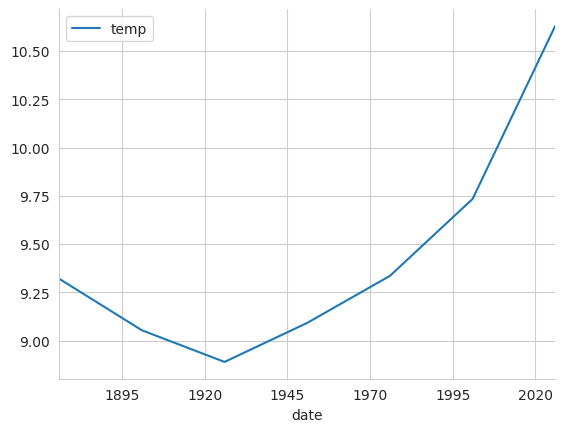

In [13]:
def resampled_mean_plot(series, years):
    s = series.copy()
    s.index = pd.to_datetime(s.index)
    resampled = s.resample(str(years)+'Y').mean()
    resampled.plot(legend=True);
    sns.despine()
resampled_mean_plot(clean_df["temp"],25)

In [14]:
clean_df.dropna(inplace=True)
# train data until Dec 31,2022
train = clean_df[:'2022-12-31']
# test data for jan 01-Dec 2023
test = clean_df['2023-01-01':]
# shape of dataframes
train.shape, test.shape

((53691, 3), (90, 3))

In [15]:
train

,temp,timestep,quality
date,,,
1876-01-01,2.2,0,0
1876-01-02,2.5,1,0
1876-01-03,0.3,2,0
1876-01-04,-5.8,3,0
1876-01-05,-9.8,4,0
...,...,...,...
2022-12-27,4.2,53686,0
2022-12-28,6.3,53687,0
2022-12-29,10.0,53688,0


In [16]:
train['denoised'] = savgol_filter(np.array(train['temp']), 99, 3, mode='nearest')
train['noise'] = train['temp'] - train['denoised']

<Axes: xlabel='date'>

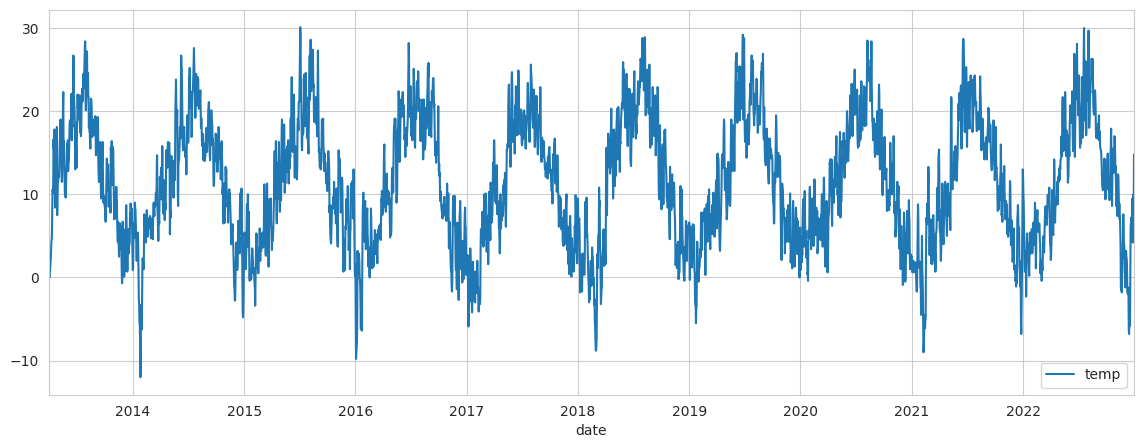

In [17]:
mpl.rcParams['figure.figsize'] = (14,5)
train["temp"]['2013-03-31':'2023-03-31'].plot(legend=True)

<Axes: xlabel='date'>

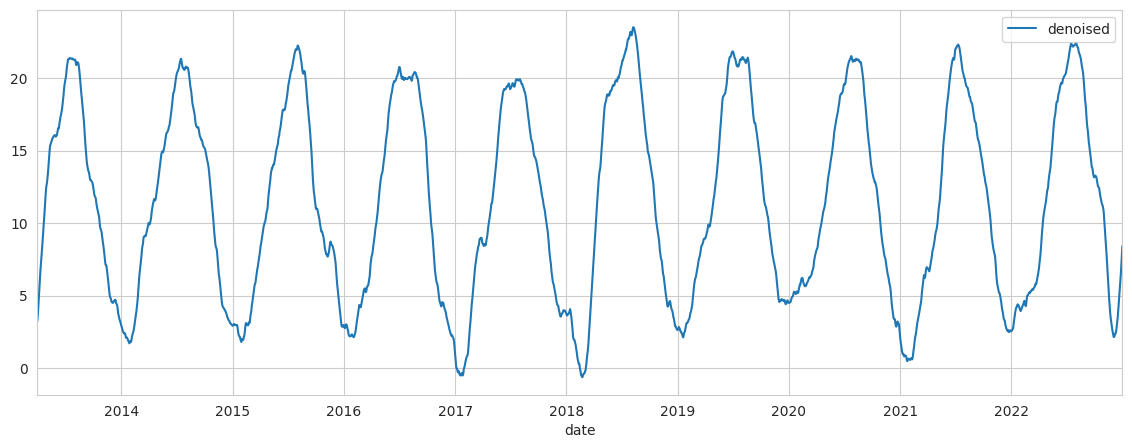

In [18]:
mpl.rcParams['figure.figsize'] = (14,5)
train['denoised']['2013-03-31':'2023-03-31'].plot(legend=True)

<Axes: xlabel='date'>

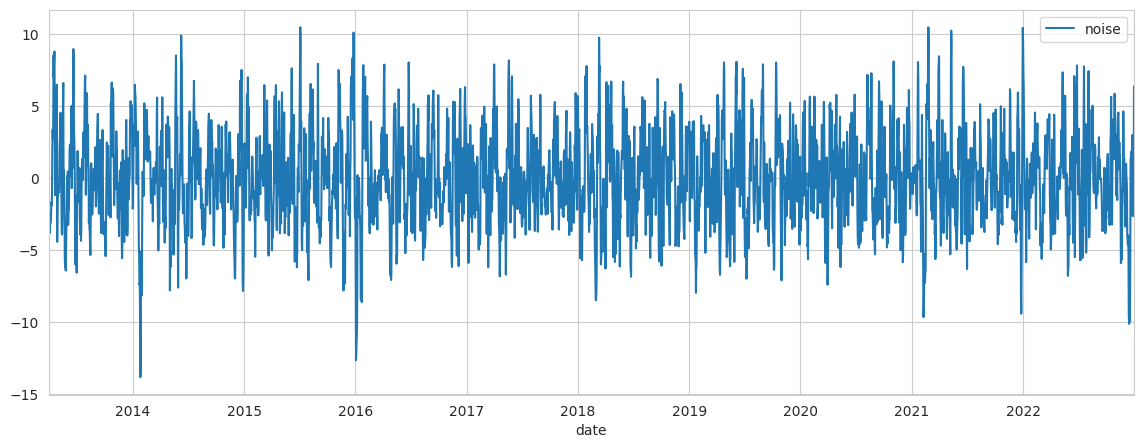

In [19]:
mpl.rcParams['figure.figsize'] = (14,5)
train['noise']['2013-03-31':'2023-03-31'].plot(legend=True)

In [20]:
# quartile coefficient of dispersion

helpy.qcd_variance(train['noise'])

0.457897

In [33]:
helpy.test_stationarity(train["denoised"])


Non-stationary: heteroscedastic (qcd = 0.777515)



In [21]:
X_trend = train[['timestep']]
y_trend = train['denoised']

In [22]:
X_trend

,timestep
date,
1876-01-01,0
1876-01-02,1
1876-01-03,2
1876-01-04,3
1876-01-05,4
...,...
2022-12-27,53686
2022-12-28,53687
2022-12-29,53688


In [23]:
#column transformer
transformer = ColumnTransformer([
    ('poly', PolynomialFeatures(), ['timestep'])])

#grid estimator
estimator = Pipeline([
        ('transformer', transformer),
        ('lr', LinearRegression())])

#parameter grid
param_grid = {'transformer__poly__degree': [2,3]}

#3-fold cross-validator
cv = TimeSeriesSplit(n_splits=3)

#instantiate GridSearchCV
gscv = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring='r2',
    cv=cv, 
    n_jobs=-1)


In [24]:
#grid-search cross-validation
# initial time
ti = time.time()

# grid-search cross-validation
gscv.fit(X_trend,y_trend)

# final time 
tf = time.time()

# time taken
print(f"time taken: {round(tf-ti,2)} sec")

time taken: 0.99 sec


In [25]:
column_list = ['param_transformer__poly__degree',
               'mean_test_score',
               'std_test_score',
               'rank_test_score'
              ]
result_df = pd.DataFrame(gscv.cv_results_)[column_list]

result_df.rename(
    columns=lambda name: name.split('__')[-1],inplace=True
)
result_df

,degree,mean_test_score,std_test_score,rank_test_score
0,2,-0.023837,0.025237,1
1,3,-1.048949,1.313547,2


In [26]:
gscv.best_params_

{'transformer__poly__degree': 2}

In [27]:
baseline_model_cv = gscv.best_estimator_
baseline_model_cv.fit(X_trend,y_trend)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('poly', PolynomialFeatures(),
                                                  ['timestep'])])),
                ('lr', LinearRegression())])

In [28]:
#predict from model
train['trend'] = baseline_model_cv.predict(X_trend)
train["detrended"] = train["denoised"] - train["trend"]
train

,temp,timestep,quality,denoised,noise,trend,detrended
date,,,,,,,
1876-01-01,2.2,0,0,-0.659391,2.859391,9.234793,-9.894184
1876-01-02,2.5,1,0,-0.772946,3.272946,9.234747,-10.007693
1876-01-03,0.3,2,0,-0.858296,1.158296,9.234700,-10.092996
1876-01-04,-5.8,3,0,-1.025494,-4.774506,9.234653,-10.260147
1876-01-05,-9.8,4,0,-1.151521,-8.648479,9.234606,-10.386128
...,...,...,...,...,...,...,...
2022-12-27,4.2,53686,0,6.827954,-2.627954,11.085904,-4.257950
2022-12-28,6.3,53687,0,7.212065,-0.912065,11.086020,-3.873954
2022-12-29,10.0,53688,0,7.611574,2.388426,11.086135,-3.474561


<Axes: xlabel='date'>

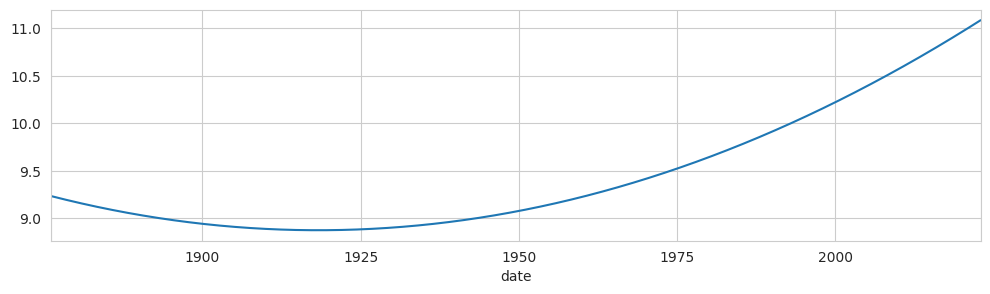

In [29]:
train['trend'].plot(figsize=(12,3))

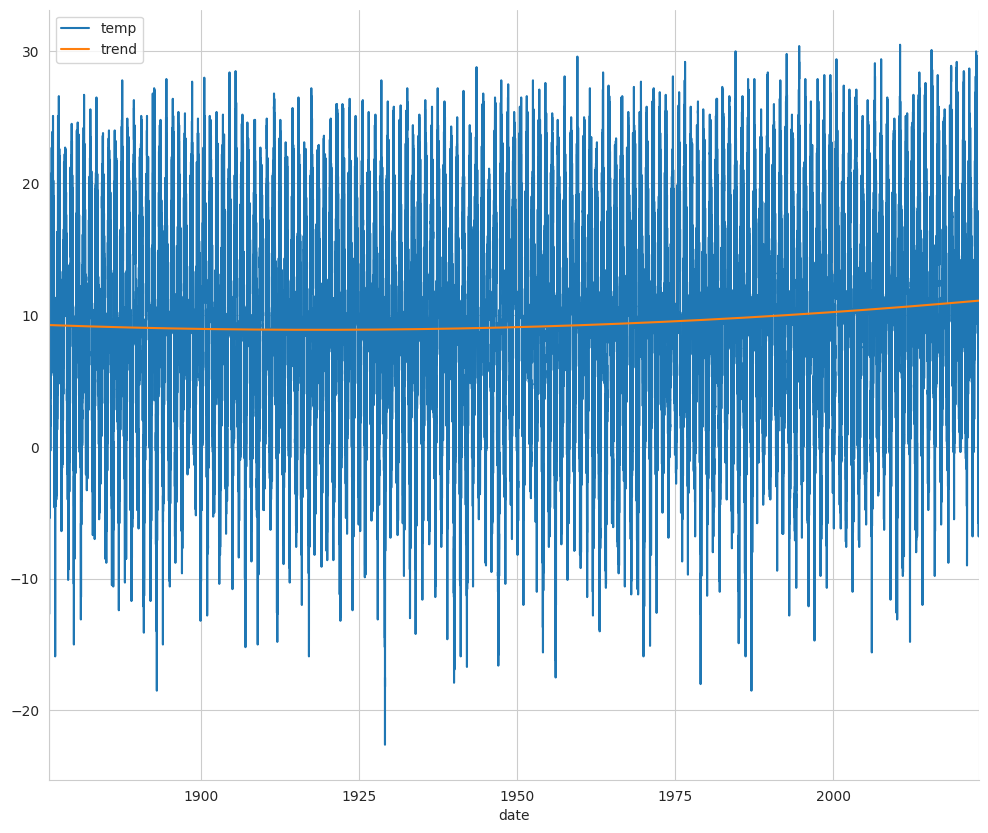

In [30]:
mpl.rc('figure',figsize=(12,10),dpi=100)

train[['temp','trend']].plot(legend=True)
sns.despine()

<Axes: xlabel='date'>

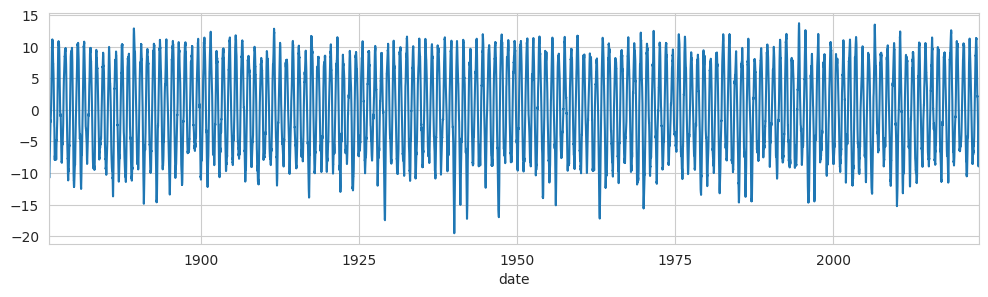

In [31]:
train['detrended'].plot(figsize=(12,3))

In [37]:
helpy.test_stationarity(train["trend"])


Non-stationary: heteroscedastic (qcd = 0.86375)



In [38]:
helpy.test_stationarity(train["detrended"])



Non-stationary: heteroscedastic (qcd = 0.777448)



In [39]:
train

,temp,timestep,quality,denoised,noise,trend,detrended
date,,,,,,,
1876-01-01,2.2,0,0,-0.659391,2.859391,9.234793,-9.894184
1876-01-02,2.5,1,0,-0.772946,3.272946,9.234747,-10.007693
1876-01-03,0.3,2,0,-0.858296,1.158296,9.234700,-10.092996
1876-01-04,-5.8,3,0,-1.025494,-4.774506,9.234653,-10.260147
1876-01-05,-9.8,4,0,-1.151521,-8.648479,9.234606,-10.386128
...,...,...,...,...,...,...,...
2022-12-27,4.2,53686,0,6.827954,-2.627954,11.085904,-4.257950
2022-12-28,6.3,53687,0,7.212065,-0.912065,11.086020,-3.873954
2022-12-29,10.0,53688,0,7.611574,2.388426,11.086135,-3.474561


In [40]:
# create year column
train['day'] = train.index.dayofyear

# feature and target for seasonality model

X_seasonality = train[['day']]
y_seasonality = train['detrended']

# seasonality model
seasonality_model = make_pipeline(
    OneHotEncoder(),
    LinearRegression())

In [41]:
# fit model
seasonality_model.fit(X_seasonality, y_seasonality)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('linearregression', LinearRegression())])

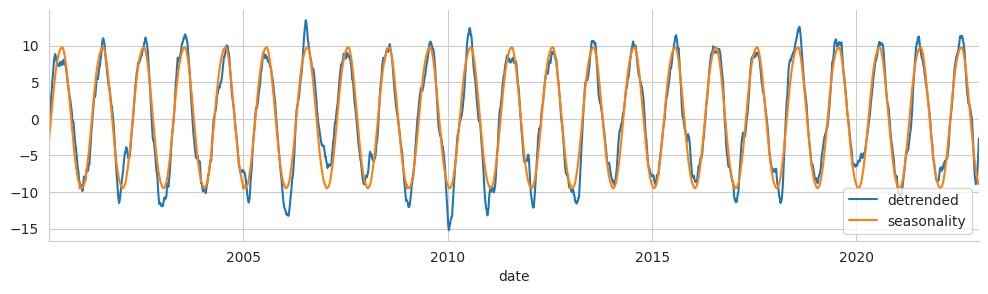

In [42]:
#predict from model
train['seasonality'] = seasonality_model.predict(X_seasonality)

#Plot seasonality and detrended data
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['detrended','seasonality']]['2000-03-31':].plot(legend=True)
sns.despine()

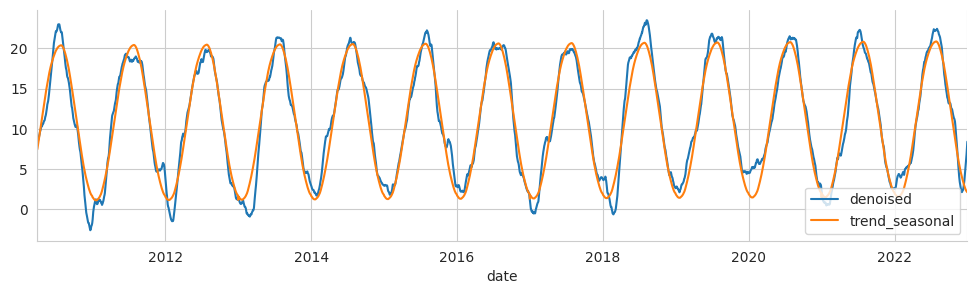

In [43]:
# combine trend and seasonality
train['trend_seasonal'] = train['trend'] + train['seasonality']

mpl.rc('figure',figsize=(12,3),dpi=100)
train[['denoised','trend_seasonal']]['2010-03-31':].plot(legend=True)
sns.despine()

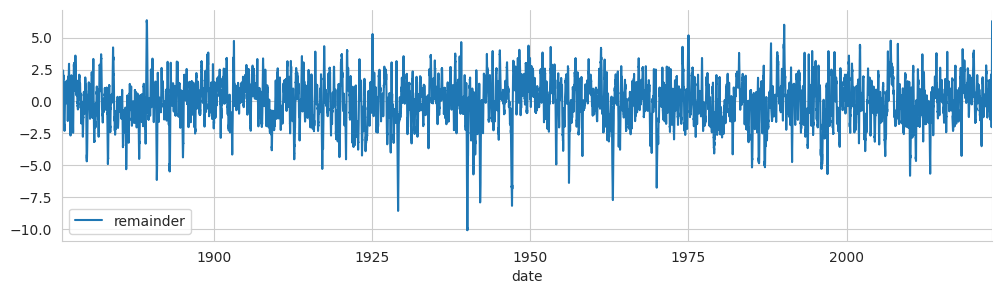

In [44]:
# leftover time series devoid of trend and seasonality

train['remainder'] = train['denoised'] - train['trend_seasonal']
#Plot remainder
mpl.rc('figure',figsize=(12,3),dpi=100)

train['remainder'].plot(legend=True)
sns.despine()

In [47]:
helpy.test_stationarity(train["seasonality"])


Non-stationary: heteroscedastic (qcd = 0.755579)



In [49]:
helpy.test_stationarity(train["remainder"])


Non-stationary: heteroscedastic (qcd = 0.756349)



In [50]:
train

,temp,timestep,quality,denoised,noise,trend,detrended,day,seasonality,trend_seasonal,remainder
date,,,,,,,,,,,
1876-01-01,2.2,0,0,-0.659391,2.859391,9.234793,-9.894184,1,-9.067679,0.167114,-0.826505
1876-01-02,2.5,1,0,-0.772946,3.272946,9.234747,-10.007693,2,-9.103861,0.130886,-0.903832
1876-01-03,0.3,2,0,-0.858296,1.158296,9.234700,-10.092996,3,-9.141828,0.092872,-0.951168
1876-01-04,-5.8,3,0,-1.025494,-4.774506,9.234653,-10.260147,4,-9.176523,0.058131,-1.083625
1876-01-05,-9.8,4,0,-1.151521,-8.648479,9.234606,-10.386128,5,-9.206905,0.027701,-1.179223
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,4.2,53686,0,6.827954,-2.627954,11.085904,-4.257950,361,-8.820279,2.265625,4.562329
2022-12-28,6.3,53687,0,7.212065,-0.912065,11.086020,-3.873954,362,-8.848868,2.237152,4.974914
2022-12-29,10.0,53688,0,7.611574,2.388426,11.086135,-3.474561,363,-8.883836,2.202300,5.409274


In [51]:
# maximum number of lags to consider
p = 6
# create lag columns in dataframe
train = helpy.create_lagged_features(train, p)
# Drop missing values
train.dropna(inplace=True)
train

,temp,timestep,quality,denoised,noise,trend,detrended,day,seasonality,trend_seasonal,remainder,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
date,,,,,,,,,,,,,,,,,
1876-01-07,-6.6,6,0,-1.237722,-5.362278,9.234513,-10.472235,7,-9.278351,-0.043838,-1.193885,-1.204634,-1.179223,-1.083625,-0.951168,-0.903832,-0.826505
1876-01-08,-8.9,7,0,-1.272669,-7.627331,9.234466,-10.507135,8,-9.309849,-0.075382,-1.197287,-1.193885,-1.204634,-1.179223,-1.083625,-0.951168,-0.903832
1876-01-09,-12.7,8,0,-1.346704,-11.353296,9.234420,-10.581123,9,-9.340562,-0.106142,-1.240562,-1.197287,-1.193885,-1.204634,-1.179223,-1.083625,-0.951168
1876-01-10,-8.9,9,0,-1.413318,-7.486682,9.234373,-10.647690,10,-9.374006,-0.139634,-1.273684,-1.240562,-1.197287,-1.193885,-1.204634,-1.179223,-1.083625
1876-01-11,-6.2,10,0,-1.390127,-4.809873,9.234326,-10.624453,11,-9.398854,-0.164528,-1.225599,-1.273684,-1.240562,-1.197287,-1.193885,-1.204634,-1.179223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,4.2,53686,0,6.827954,-2.627954,11.085904,-4.257950,361,-8.820279,2.265625,4.562329,4.184478,3.865960,3.527256,3.176495,2.849479,2.497795
2022-12-28,6.3,53687,0,7.212065,-0.912065,11.086020,-3.873954,362,-8.848868,2.237152,4.974914,4.562329,4.184478,3.865960,3.527256,3.176495,2.849479
2022-12-29,10.0,53688,0,7.611574,2.388426,11.086135,-3.474561,363,-8.883836,2.202300,5.409274,4.974914,4.562329,4.184478,3.865960,3.527256,3.176495


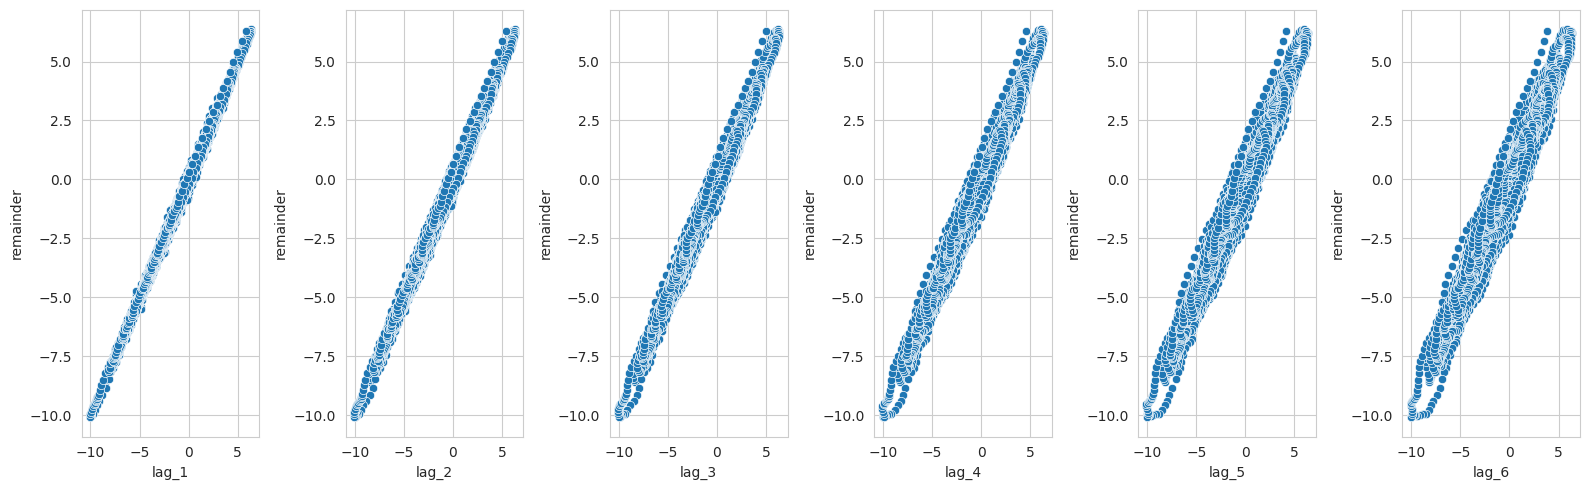

In [52]:
import matplotlib.gridspec as gridspec

lag_columns = train.columns[-p:]
fig, axes = plt.subplots(1,p, figsize=(16,5),dpi=100)
gs = gridspec.GridSpec(1,p)

for i in range(p): sns.scatterplot(x=train[lag_columns[i]], y=train["remainder"], ax=axes[i])

    
plt.tight_layout()

<Figure size 1000x200 with 0 Axes>

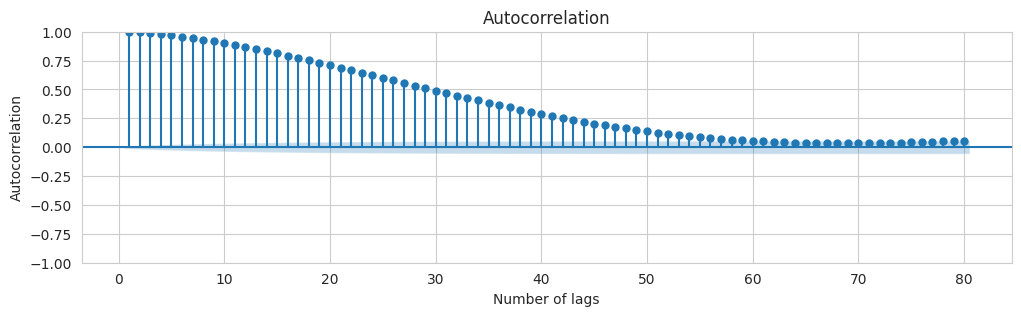

In [53]:
# plot autocorrelation function
helpy.auto_correlation_plot(train['remainder'], 80)

<Figure size 1000x200 with 0 Axes>

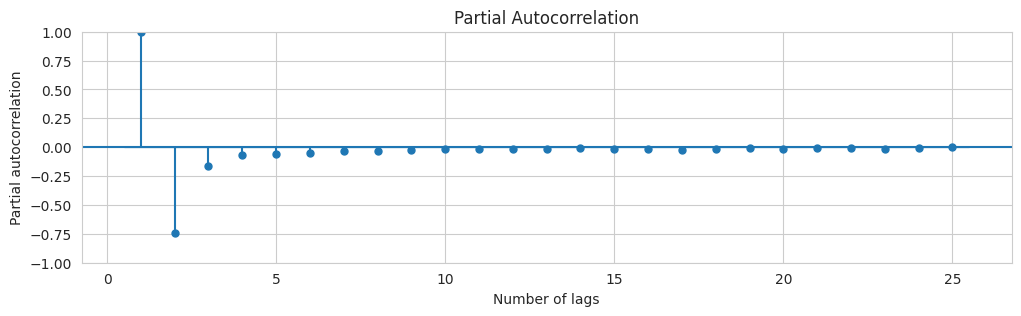

In [54]:
# plot autocorrelation function
helpy.partial_auto_correlation_plot(train['remainder'])

In [56]:
import pmdarima as pm
arima_model = pm.auto_arima(
    train['remainder'], 
    start_p=0,
    max_p=8,
    seasonality = False,
    stationarity = True,
    trace = True,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=73809.527, Time=12.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=211071.107, Time=0.73 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=8.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=138223.805, Time=9.64 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=211069.107, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-142565.509, Time=18.44 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-129805.222, Time=9.41 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-155891.528, Time=36.73 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-155740.835, Time=22.89 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-154610.934, Time=73.58 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-156140.876, Time=39.55 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-147860.125, Time=30.28 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-156253.346, Time=32.04 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=-156296.815, Time=18.47

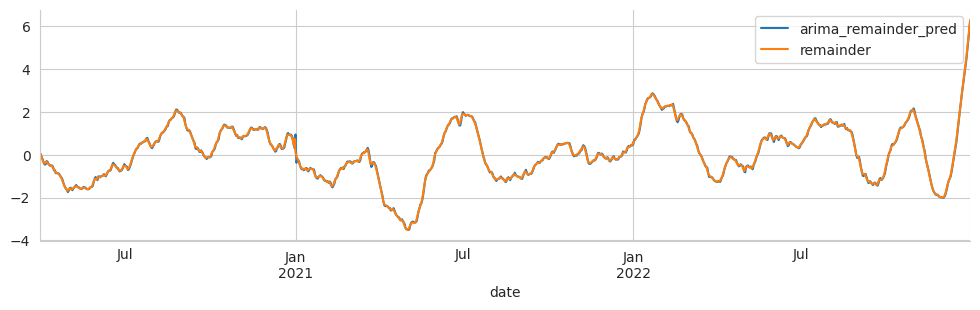

In [57]:
train['arima_remainder_pred'] = arima_model.predict_in_sample()

mpl.rc('figure',figsize=(12,3),dpi=100)
train[['arima_remainder_pred','remainder']]['2020-03-31':].plot(legend=True)
sns.despine()

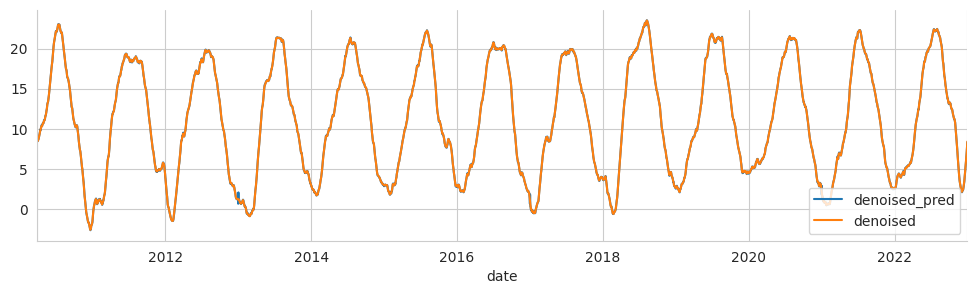

In [58]:
train['denoised_pred'] = train['trend_seasonal'] + train['arima_remainder_pred']

mpl.rc('figure',figsize=(12,3),dpi=100)
train[['denoised_pred','denoised']]['2010-03-31':].plot(legend=True)
sns.despine()

In [62]:
helpy.test_stationarity(train["arima_remainder_pred"])


Non-stationary: heteroscedastic (qcd = 0.725921)



In [63]:
helpy.test_stationarity(train["denoised_pred"])


Non-stationary: heteroscedastic (qcd = 0.760985)



In [64]:
train

,temp,timestep,quality,denoised,noise,trend,detrended,day,seasonality,trend_seasonal,remainder,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,arima_remainder_pred,denoised_pred
date,,,,,,,,,,,,,,,,,,,
1876-01-07,-6.6,6,0,-1.237722,-5.362278,9.234513,-10.472235,7,-9.278351,-0.043838,-1.193885,-1.204634,-1.179223,-1.083625,-0.951168,-0.903832,-0.826505,0.000000,-0.043838
1876-01-08,-8.9,7,0,-1.272669,-7.627331,9.234466,-10.507135,8,-9.309849,-0.075382,-1.197287,-1.193885,-1.204634,-1.179223,-1.083625,-0.951168,-0.903832,-1.191994,-1.267377
1876-01-09,-12.7,8,0,-1.346704,-11.353296,9.234420,-10.581123,9,-9.340562,-0.106142,-1.240562,-1.197287,-1.193885,-1.204634,-1.179223,-1.083625,-0.951168,-1.196613,-1.302755
1876-01-10,-8.9,9,0,-1.413318,-7.486682,9.234373,-10.647690,10,-9.374006,-0.139634,-1.273684,-1.240562,-1.197287,-1.193885,-1.204634,-1.179223,-1.083625,-1.269411,-1.409044
1876-01-11,-6.2,10,0,-1.390127,-4.809873,9.234326,-10.624453,11,-9.398854,-0.164528,-1.225599,-1.273684,-1.240562,-1.197287,-1.193885,-1.204634,-1.179223,-1.296344,-1.460872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,4.2,53686,0,6.827954,-2.627954,11.085904,-4.257950,361,-8.820279,2.265625,4.562329,4.184478,3.865960,3.527256,3.176495,2.849479,2.497795,4.449381,6.715006
2022-12-28,6.3,53687,0,7.212065,-0.912065,11.086020,-3.873954,362,-8.848868,2.237152,4.974914,4.562329,4.184478,3.865960,3.527256,3.176495,2.849479,4.869462,7.106614
2022-12-29,10.0,53688,0,7.611574,2.388426,11.086135,-3.474561,363,-8.883836,2.202300,5.409274,4.974914,4.562329,4.184478,3.865960,3.527256,3.176495,5.308866,7.511166


<Figure size 1000x200 with 0 Axes>

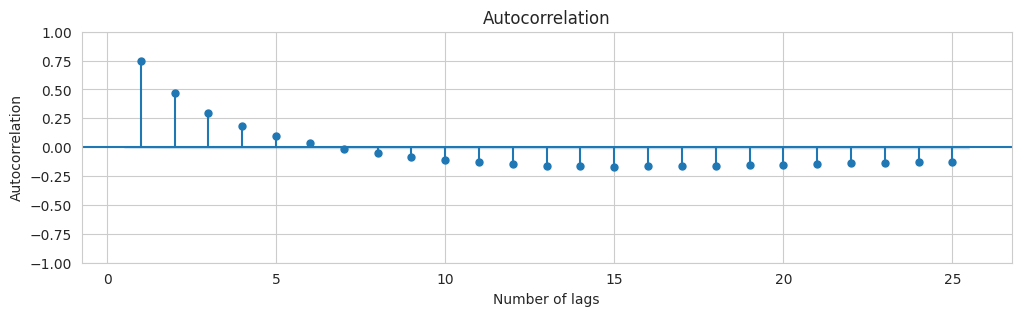

In [65]:
# plot autocorrelation function
helpy.auto_correlation_plot(train['noise'], 25)

<Figure size 1000x200 with 0 Axes>

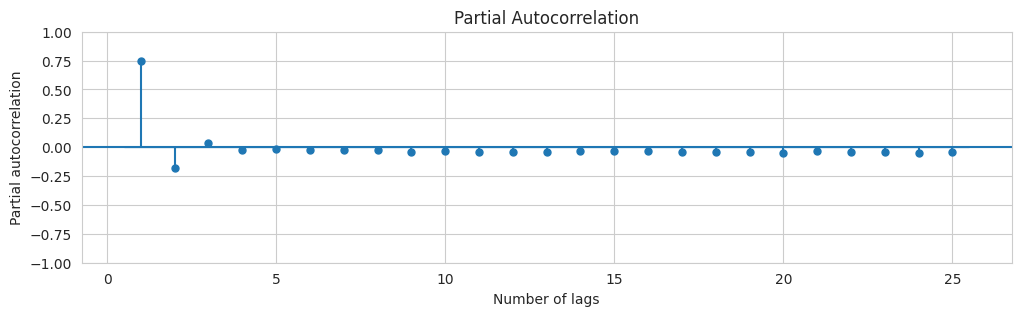

In [66]:
# plot partial autocorrelation function
helpy.partial_auto_correlation_plot(train['noise'])

In [67]:
arima_noise_model = pm.auto_arima(
    train['noise'], 
    start_p=0,
    max_p=3,
    start_q=0,
    max_q=1,
    seasonality = False,
    stationarity = True,
    trace = True,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=280974.385, Time=0.72 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=237916.703, Time=1.68 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=248810.064, Time=4.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=280972.392, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=236214.780, Time=2.62 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=236151.392, Time=3.38 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=236138.799, Time=12.38 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=236138.924, Time=7.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=236136.800, Time=3.32 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=236136.925, Time=1.64 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=236149.393, Time=0.98 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=236212.781, Time=0.59 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0]          
Total fit time: 38.852 seconds


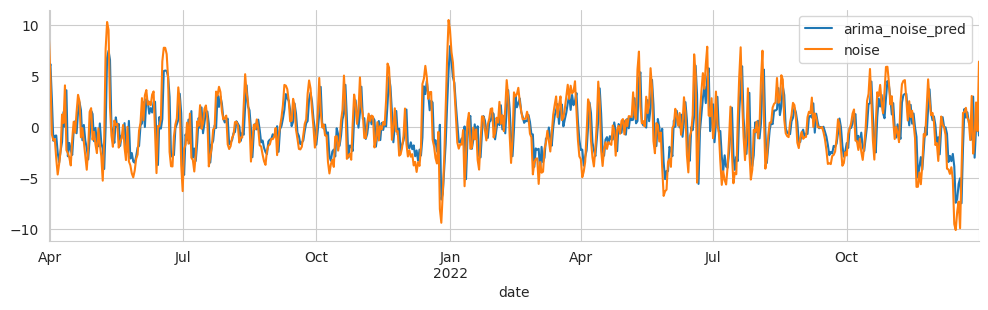

In [68]:
train['arima_noise_pred'] = arima_noise_model.predict_in_sample()
mpl.rc('figure',figsize=(12,3),dpi=100)
train[['arima_noise_pred','noise']]['2021-03-31':].plot(legend=True)
sns.despine()

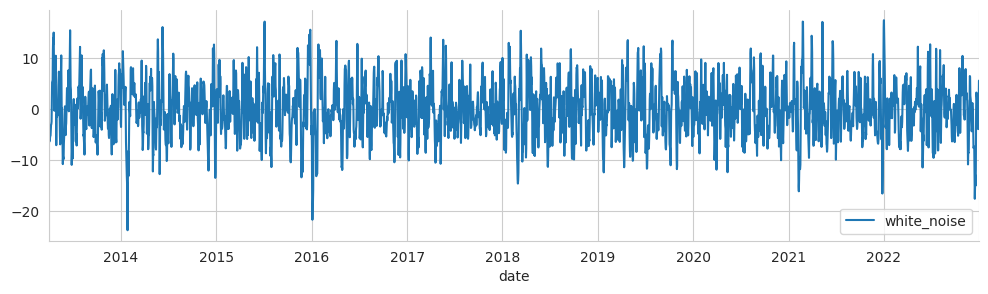

In [69]:
train['white_noise'] = train['noise'] + train['arima_noise_pred']
#Plot white noise
mpl.rc('figure',figsize=(12,3),dpi=100)

train['white_noise']['2013-03-31':'2023-03-31'].plot(legend=True)
sns.despine()

In [72]:
train.tail()

,temp,timestep,quality,denoised,noise,trend,detrended,day,seasonality,trend_seasonal,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,arima_remainder_pred,denoised_pred,arima_noise_pred,white_noise
date,,,,,,,,,,,,,,,,,,,,,
2022-12-27,4.2,53686,0,6.827954,-2.627954,11.085904,-4.257950,361,-8.820279,2.265625,...,4.184478,3.865960,3.527256,3.176495,2.849479,2.497795,4.449381,6.715006,2.956834,0.328881
2022-12-28,6.3,53687,0,7.212065,-0.912065,11.086020,-3.873954,362,-8.848868,2.237152,...,4.562329,4.184478,3.865960,3.527256,3.176495,2.849479,4.869462,7.106614,-3.023428,-3.935494
2022-12-29,10.0,53688,0,7.611574,2.388426,11.086135,-3.474561,363,-8.883836,2.202300,...,4.974914,4.562329,4.184478,3.865960,3.527256,3.176495,5.308866,7.511166,-0.078754,2.309672
2022-12-30,7.6,53689,0,8.021626,-0.421626,11.086251,-3.064625,364,-8.922330,2.163921,...,5.409274,4.974914,4.562329,4.184478,3.865960,3.527256,5.757858,7.921779,2.112499,1.690873
2022-12-31,14.8,53690,0,8.411407,6.388593,11.086367,-2.674959,365,-8.965668,2.120699,...,5.857705,5.409274,4.974914,4.562329,4.184478,3.865960,6.216978,8.337676,-0.857253,5.531340


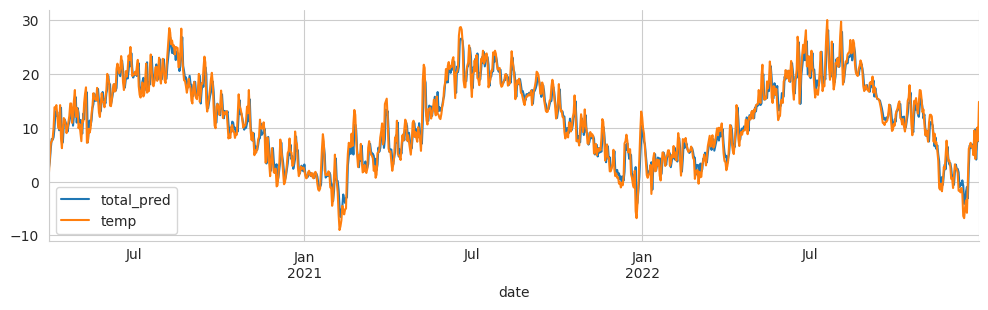

In [74]:
train['total_pred'] = train['denoised_pred'] + train['arima_noise_pred']

mpl.rc('figure',figsize=(12,3),dpi=100)
train[['total_pred','temp']]['2020-03-31':].plot(legend=True)
sns.despine()

In [75]:
helpy.test_stationarity(train["total_pred"])


p_adf: 0.0, p_kpss: 0.085071
Stationary or seasonal-stationary


In [77]:
test

,temp,timestep,quality
date,,,
2023-01-01,14.5,53691,0
2023-01-02,13.1,53692,0
2023-01-03,5.6,53693,0
2023-01-04,7.1,53694,0
2023-01-05,8.2,53695,0
...,...,...,...
2023-03-27,3.4,53776,0
2023-03-28,3.5,53777,0
2023-03-29,6.6,53778,0


In [78]:
X_trend_ = test[['timestep']]
test['trend'] = baseline_model_cv.predict(X_trend_)

test['day'] = test.index.dayofyear
X_seasonality = test[['day']]
test['seasonality'] = seasonality_model.predict(X_seasonality)
test['arima_remainder_pred'] = arima_model.predict(len(test))
test['arima_noise_pred'] = arima_noise_model.predict(len(test))

test['total_pred'] = test['trend'] + test['seasonality'] + test['arima_remainder_pred'] + test['arima_noise_pred']


In [79]:
test

,temp,timestep,quality,trend,day,seasonality,arima_remainder_pred,arima_noise_pred,total_pred
date,,,,,,,,,
2023-01-01,14.5,53691,0,11.086482,1,-9.067679,6.639491,5.825800e+00,14.484095
2023-01-02,13.1,53692,0,11.086598,2,-9.103861,6.925143,3.724947e+00,12.632828
2023-01-03,5.6,53693,0,11.086714,3,-9.141828,7.161376,2.377742e+00,11.484004
2023-01-04,7.1,53694,0,11.086830,4,-9.176523,7.359027,1.476640e+00,10.745974
2023-01-05,8.2,53695,0,11.086945,5,-9.206905,7.523990,9.202137e-01,10.324244
...,...,...,...,...,...,...,...,...,...
2023-03-27,3.4,53776,0,11.096329,86,-3.748413,-0.389843,1.705984e-17,6.958073
2023-03-28,3.5,53777,0,11.096445,87,-3.590867,-0.421857,1.060252e-17,7.083721
2023-03-29,6.6,53778,0,11.096561,88,-3.433318,-0.451347,6.589356e-18,7.211897


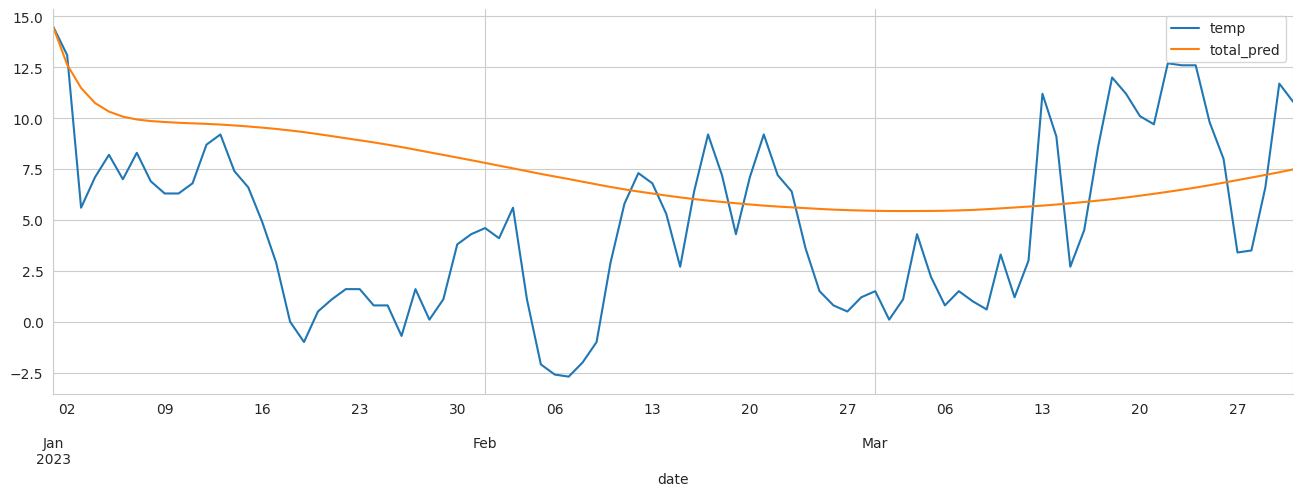

In [80]:
mpl.rc("figure", figsize=(16, 5))
test[["temp", "total_pred"]].plot(legend=True)
sns.despine()

In [84]:
full_df=pd.concat([train[["temp", "timestep", "total_pred"]],test[["temp", "timestep", "total_pred"]]])
full_df

,temp,timestep,total_pred
date,,,
1876-01-07,-6.6,6,-0.043838
1876-01-08,-8.9,7,-5.250129
1876-01-09,-12.7,8,-7.021372
1876-01-10,-8.9,9,-10.009385
1876-01-11,-6.2,10,-5.953009
...,...,...,...
2023-03-27,3.4,53776,6.958073
2023-03-28,3.5,53777,7.083721
2023-03-29,6.6,53778,7.211897


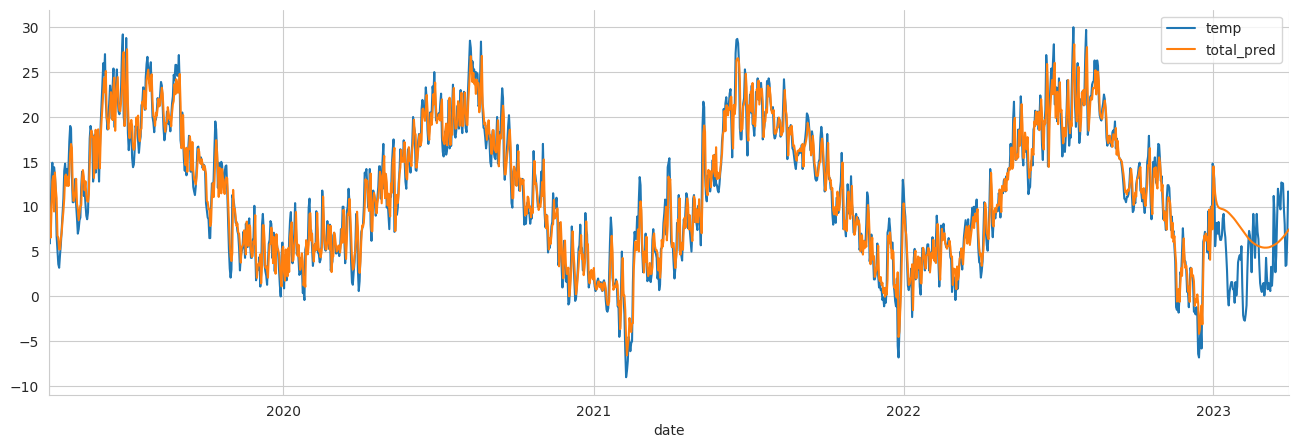

In [85]:
mpl.rc("figure", figsize=(16, 5))
full_df[["temp", "total_pred"]]["2019-03-31":].plot(legend=True)
sns.despine()

In [86]:
full_df

,temp,timestep,total_pred
date,,,
1876-01-07,-6.6,6,-0.043838
1876-01-08,-8.9,7,-5.250129
1876-01-09,-12.7,8,-7.021372
1876-01-10,-8.9,9,-10.009385
1876-01-11,-6.2,10,-5.953009
...,...,...,...
2023-03-27,3.4,53776,6.958073
2023-03-28,3.5,53777,7.083721
2023-03-29,6.6,53778,7.211897


In [87]:
from pandas.tseries.offsets import DateOffset
future_predictions=[full_df.index[-1]+ DateOffset(days=x)for x in range(8)]
future_predictions_df=pd.DataFrame(index=future_predictions[1:],columns=full_df.columns[1:])
future_predictions_df["timestep"] = list(range(1,future_predictions_df.shape[0]+1))
future_predictions_df.drop(["total_pred"], axis=1, inplace=True)
future_predictions_df.head()

,timestep
2023-04-01,1
2023-04-02,2
2023-04-03,3
2023-04-04,4
2023-04-05,5


In [88]:
X_trend_ = future_predictions_df[['timestep']]
future_predictions_df['trend'] = baseline_model_cv.predict(X_trend_)

future_predictions_df['day'] = future_predictions_df.index.dayofyear
X_seasonality = future_predictions_df[['day']]
future_predictions_df['seasonality'] = seasonality_model.predict(X_seasonality)
future_predictions_df['arima_remainder_pred'] = pd.array(arima_model.predict(len(future_predictions_df)))
future_predictions_df['arima_noise_pred'] = pd.array(arima_noise_model.predict(len(future_predictions_df)))

future_predictions_df['total_pred'] = future_predictions_df['trend'] + future_predictions_df['seasonality'] + future_predictions_df['arima_remainder_pred'] + future_predictions_df['arima_noise_pred']


In [89]:
future_predictions_df[["timestep", "total_pred"]]

,timestep,total_pred
2023-04-01,1,18.756741
2023-04-02,2,17.109683
2023-04-03,3,16.165507
2023-04-04,4,15.616642
2023-04-05,5,15.380494
2023-04-06,6,15.326219
2023-04-07,7,15.384659
